In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import glob
from datetime import datetime

In [74]:
PUSHSHIFT_OUTPUT_DIR = 'pushshift_output'
PRAW_OUTPUT_DIR = 'praw_output'
POSTS_DIR = 'posts'
COMMENTS_DIR = 'post_comments'

# Posts

Gathering all the Pushshift and PRAW output and dropping duplicate posts, we have 1.27M posts total.

In [76]:
pushshift_dfs = [pd.read_pickle(f) for f in glob.glob(os.path.join(PUSHSHIFT_OUTPUT_DIR,POSTS_DIR,'*','*.pkl'))]
pushshift_dfs = [x for x in pushshift_dfs if len(x) > 0]
all_pushshift_posts = pd.concat(pushshift_dfs,axis=0)
unique_pushshift_posts = all_pushshift_posts.drop_duplicates('id',keep='first')

praw_dfs = [pd.read_csv(f,sep='\t',header=0) for f in glob.glob(os.path.join(PRAW_OUTPUT_DIR,POSTS_DIR,'*.tsv'))]
all_praw_posts = pd.concat(praw_dfs,axis=0)
unique_praw_posts = all_praw_posts.drop_duplicates('id',keep='first')

print('Number of unique Pushshift posts, PRAW posts: {}, {}'.format(len(unique_pushshift_posts),
                                                                    len(unique_praw_posts)))

print('Fields from PRAW that are missing from Pushshift:',[x for x in all_praw_posts.columns if x not in 
                                                          unique_pushshift_posts.columns])
      
all_posts = pd.concat([unique_pushshift_posts,unique_praw_posts],axis=0)
unique_posts = all_posts.drop_duplicates('id',keep='first')
print('Number of unique posts, combining Pushshift and PRAW:',len(unique_posts))

Number of unique Pushshift posts, PRAW posts: 1244195, 31569
Fields from PRAW that are missing from Pushshift: ['num_downs', 'num_ups']
Number of unique posts, combining Pushshift and PRAW: 1271538


In [77]:
unique_posts.columns

Index(['id', 'title', 'url', 'author', 'score', 'date', 'num_comments',
       'permalink', 'flair', 'is_video', 'upvote_ratio', 'text', 'subreddit',
       'num_downs', 'num_ups'],
      dtype='object')

In [133]:
# Add column for parsed date
unique_posts['parsed_date'] = unique_posts.date.apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isnull(x)
                                                     and type(x) == float else x)
# Extract month, year
unique_posts['year'] = unique_posts.parsed_date.apply(lambda x: x.year if not pd.isnull(x)
                                                     else None)
unique_posts['month'] = unique_posts.parsed_date.apply(lambda x: x.month if not pd.isnull(x)
                                                     else None)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

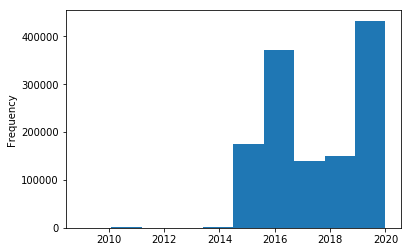

In [135]:
unique_posts['year'].plot.hist()

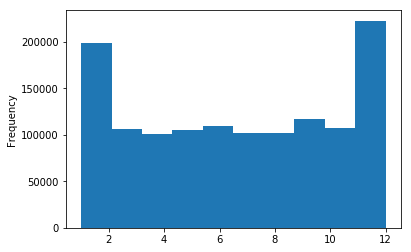

In [136]:
unique_posts['month'].plot.hist()

In [78]:
unique_posts.flair.value_counts()

NaN                1138770
Environment           5946
Earth Sciences        4148
Discussion            2443
Question              2207
                    ...   
2011                     1
Shen Bapiro              1
8==m==D~~                1
German                   1
True FellowKids          1
Name: flair, Length: 9762, dtype: int64

There are 2.5k video posts:

In [79]:
unique_posts.is_video.value_counts()

False    676821
True       2544
Name: is_video, dtype: int64

There are 800k posts that have some form of text, in either the title or body.

In [84]:
unique_posts.loc[(unique_posts.text.apply(lambda x: len(x) > 0 if type(x) == 'str' else False)) |
                          (unique_posts.title.apply(lambda x: len(x) > 0 
                                                             if x is not None and type(x) != 'float'
                                                    else False))].shape

(838807, 15)

There are the same number of posts with just text in the title, meaning that a strict subset of the titled posts have body text.

In [89]:
unique_posts.loc[(unique_posts.title.apply(lambda x: len(x) > 0 if x is not None and type(x) != 'float' 
                                           else False))].shape

(838807, 15)

Only 218k posts have body text:

In [111]:
unique_posts.loc[(~pd.isnull(unique_posts.text)) &
                unique_posts.text.apply(lambda x: x is not None) &
                unique_posts.text.apply(lambda x: type(x) != 'float')][unique_posts.loc[(~pd.isnull(unique_posts.text)) &
                unique_posts.text.apply(lambda x: x is not None) &
                unique_posts.text.apply(lambda x: type(x) != 'float')].text.apply(lambda x: len(x) > 0)].shape

(217721, 15)

All posts have a score; only 62k have an upvote ratio. Oddly, the posts with a non-null number of comments (incl. 0) seem to be the same as those with some kind of title or body text?

In [112]:
print(unique_posts.loc[~pd.isnull(unique_posts.score)].shape,
unique_posts.loc[~pd.isnull(unique_posts.num_comments)].shape,
unique_posts.loc[~pd.isnull(unique_posts.upvote_ratio)].shape)

(1271537, 15) (838806, 15) (62150, 15)


Number of posts with both text and upvote ratio is the same as number of posts with upvote ratio:

In [113]:
unique_posts.loc[(~pd.isnull(unique_posts.upvote_ratio)) & 
                          (unique_posts.title.apply(lambda x: len(x) > 0 
                                                             if x is not None else False))].shape

(62150, 15)

Number of posts with both text and score is the same as number of posts with text, since all posts have a score.

In [114]:
unique_posts.loc[(~pd.isnull(unique_posts.score)) & 
                          (unique_posts.title.apply(lambda x: len(x) > 0 
                                                             if x is not None else False))].shape

(838806, 15)

We want both text and an outcome for using Reid's model. We can use either the title text, or title text and body text, as X and have the same size of X.

* X = text (title, or both title and body), N = 838,807
* Y = upvote ratio, N = 62,150
* Y = score, N = 838,806

(Do any of the texted posts represent videos?) They all do!

In [115]:
unique_posts.loc[(unique_posts.is_video) & 
                          (unique_posts.title.apply(lambda x: len(x) > 0 
                                                             if x is not None else False))].shape

(2544, 15)

We also want some variables to control for using Reid's model. Let's examine which of these are missing from the potential X, Y: author, date, is_video, subreddit.

In [116]:
print(
    unique_posts.loc[~pd.isnull(unique_posts.author)].shape,
    unique_posts.loc[~pd.isnull(unique_posts.date)].shape,
    unique_posts.loc[~pd.isnull(unique_posts.is_video)].shape,
    unique_posts.loc[~pd.isnull(unique_posts.subreddit)].shape
)

(1271537, 15) (1271537, 15) (679365, 15) (1271372, 15)


Other than whether or not a post is a video, most posts have all 4 attributes.

We have representation from 32k subreddits and 391k users.

In [117]:
print(len(unique_posts.loc[~pd.isnull(unique_posts.subreddit)].subreddit.value_counts()),
      len(unique_posts.loc[~pd.isnull(unique_posts.author)].author.value_counts()))

32573 391015


# Comments

We have 3.6M unique comments, combining Pushshift and PRAW.

In [138]:
unique_pushshift_comments.columns

Index(['id', 'author', 'score', 'date', 'permalink', 'text', 'subreddit'], dtype='object')

In [139]:
unique_praw_comments.columns

Index(['submission_id', 'author', 'text', 'date', 'id', 'controversiality',
       'num_downs', 'num_ups', 'num_likes', 'score', 'subreddit'],
      dtype='object')

In [118]:
pushshift_dfs = [pd.read_pickle(f) for f in glob.glob(os.path.join(PUSHSHIFT_OUTPUT_DIR,COMMENTS_DIR,'*','*.pkl'))]
pushshift_dfs = [x for x in pushshift_dfs if len(x) > 0]
all_pushshift_comments = pd.concat(pushshift_dfs,axis=0)
unique_pushshift_comments = all_pushshift_comments.drop_duplicates('id',keep='first')

praw_dfs = [pd.read_csv(f,sep='\t',header=0) for f in glob.glob(os.path.join(PRAW_OUTPUT_DIR,COMMENTS_DIR,'*.tsv'))]
all_praw_comments = pd.concat(praw_dfs,axis=0)
unique_praw_comments = all_praw_comments.drop_duplicates('id',keep='first')

print('Number of unique Pushshift, PRAW comments: {}, {}'.format(len(unique_pushshift_comments),
                                                                    len(unique_praw_comments)))

print('Fields from PRAW that are missing from Pushshift:',[x for x in all_praw_comments.columns if x not in 
                                                          unique_pushshift_comments.columns])
      
all_comments = pd.concat([unique_pushshift_comments,unique_praw_comments],axis=0)
unique_comments = all_comments.drop_duplicates('id',keep='first')
print('Number of unique comments, combining Pushshift and PRAW:',len(unique_comments))

Number of unique Pushshift, PRAW comments: 3605556, 370
Fields from PRAW that are missing from Pushshift: ['submission_id', 'controversiality', 'num_downs', 'num_ups', 'num_likes']
Number of unique comments, combining Pushshift and PRAW: 3605917


In [137]:
unique_comments.columns 

Index(['id', 'author', 'score', 'date', 'permalink', 'text', 'subreddit',
       'submission_id', 'controversiality', 'num_downs', 'num_ups',
       'num_likes'],
      dtype='object')

In [151]:
# unique_comments['parsed_date'] = unique_comments.date.apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isnull(x)
#                                                      and type(x) == float else x)
# # Extract month, year
# unique_comments['year'] = unique_comments.parsed_date.apply(lambda x: x.year if not 
#                                                            pd.isnull(x) else None)
# unique_comments['month'] = unique_comments.parsed_date.apply(lambda x: x.month if not 
#                                                            pd.isnull(x) else None)

## Explore distribution of each attribute 

In [146]:
## Time

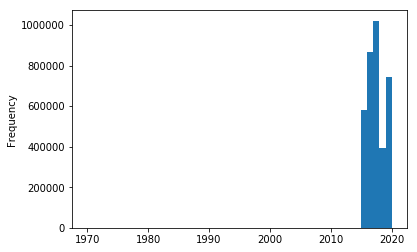

In [144]:
unique_comments['year'].plot.hist(bins=50)

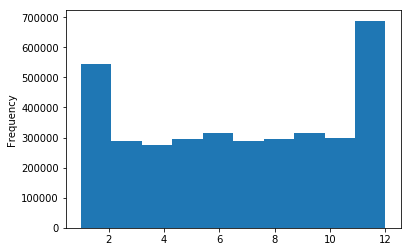

In [145]:
unique_comments['month'].plot.hist()

Main X, Y for model (text and engagement signals):

All 3.6M comments have text.

In [149]:
unique_comments.loc[(unique_comments.text.apply(lambda x: len(x) > 0))].shape

(3605917, 15)

Number of words in comments, where "words" are just split on whitespace:

In [153]:
unique_comments['num_words'] = unique_comments.text.apply(lambda x: len(x.split()))#.hist()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Log #words in comments is normally distributed:

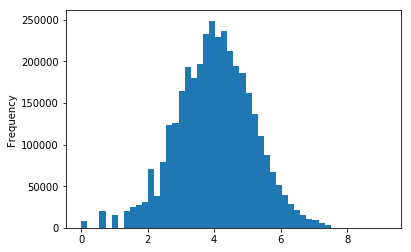

In [163]:
unique_comments['num_words'].apply(lambda x: np.log(x)).plot.hist(bins=50)

Most comments only have score as an engagement metric:

In [164]:
print(unique_comments.loc[~pd.isnull(unique_comments.score)].shape,
unique_comments.loc[~pd.isnull(unique_comments.controversiality)].shape,
unique_comments.loc[~pd.isnull(unique_comments.num_ups)].shape,
     unique_comments.loc[~pd.isnull(unique_comments.num_downs)].shape,
     unique_comments.loc[~pd.isnull(unique_comments.num_likes)].shape)

(3605891, 16) (360, 16) (360, 16) (359, 16) (1, 16)


The distribution of comment scores is

In [ ]:
unique_comments.loc[~pd.isnull(unique_comments.score)].score.plot.boxplot()

We want both text and an outcome for using Reid's model. We are constrained only by the size of Y if we use something other than score as Y. All datapoints have X, the text.

* X = text, N = 3,605,917
* Y = score, N = 3,605,891
* Y = not score, N = 360

What variables can we control for? Basically all of author, date, and subreddit.

In [174]:
print(
    unique_comments.loc[~pd.isnull(unique_comments.author)].shape,
    unique_comments.loc[~pd.isnull(unique_comments.date)].shape,
    unique_comments.loc[~pd.isnull(unique_comments.subreddit)].shape
)

(3605917, 16) (3605916, 16) (3605915, 16)


We have representation from subreddits and users.

In [ ]:
print(len(unique_comments.loc[~pd.isnull(unique_comments.subreddit)].subreddit.value_counts()),
      len(unique_comments.loc[~pd.isnull(unique_comments.author)].author.value_counts()))

Distribution of comments from different authors:

Distribution of posts/comments from different authors: AxesSubplot(0.125,0.125;0.775x0.755)


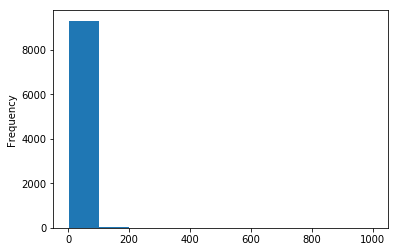

In [11]:
%matplotlib inline
unique_comments.loc[~pd.isnull(unique_comments.author)].author.value_counts().apply(lambda x: np.log(x)).plot.hist()

In [40]:
print('Distribution over controversiality of comments:')
all_comments_df.controversiality.value_counts()

Distribution over controversiality of comments:


0.0    364
1.0      5
Name: controversiality, dtype: int64

In [44]:
# Examine most controversial comments
list(all_comments_df.loc[all_comments_df.controversiality == 1.0].text)

['These have all been covered at the daily briefings.  Have you watched them?    Not sure what else can be done.    As far as the past goes, yes, H1N1 wiped out the supplies, those need refreshed.',
 "And the WHO was telling the world it wasn't contagious at that point. Meanwhile GEOTUS formed the task force and shut down travel from China, for which Dems attacked him.",
 'c0gpcim',
 "If you ask a medical professional how best to prevent the spread of the virus, an economist how best to protect peoples livelihoods, and a mental health professional the best way of protecting people's sanity...you're going to end up with some very conflicting policy.Politicians have to draw it all together and make it work. Spoilers: you can't.",
 "Because global warming has been turned into a focal point of contrarians. The word itself has been tainted, and just because it's cold out doesn't mean that global warming isn't still a huge problem."]

In [49]:
# Small bug in comment ids affecting 3 comments (does not seem consequential for now)
all_comments_df.id.apply(lambda x: type(x)).value_counts()

<class 'str'>      368
<class 'float'>      3
Name: id, dtype: int64

In [50]:
all_comments_df.loc[all_comments_df.id.apply(lambda x: type(x) == float)]

,submission_id,author,text,date,id,controversiality,num_downs,num_ups,num_likes,score,subreddit,parsed_date,year,month
0,ab3wt,heystoopid,|[Total BS](http://www.wunderground.com/blog/J...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,[And crock of the week too !](http://climatepr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,[A word from a supreme authority on this issue...,1259988777.0,c0gpcim,0.0,0,1.0,NaN,1.0,climategate,NaN,NaN,1970-01-01,1970.0,1.0


In [51]:
# But affects a lot more posts--not sure if they're truly NaNs or not
all_posts_df.id.apply(lambda x: type(x)).value_counts()

<class 'str'>      31568
<class 'float'>      733
Name: id, dtype: int64

In [52]:
all_posts_df.loc[all_posts_df.id.apply(lambda x: type(x) == float)]

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
30,|IT’S TIME TO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
31,CONNECT THE DOTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
34,|INSERT ___________ HERE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
470,Started to school strike for climate change ou...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
471,Greta Thunberg started the global movement Fri...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,|Effect of Record Drought on Amazon Studied -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
914,|Peru's arid capital in serious danger of runn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
918,|Scientists study record-breaking 2010 heatwave -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
953,|China's weather forecasters reluctant to conf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


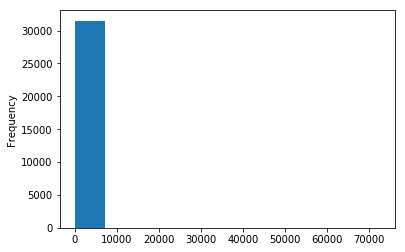

In [57]:
all_posts_df.num_ups.plot.hist(bins=10)

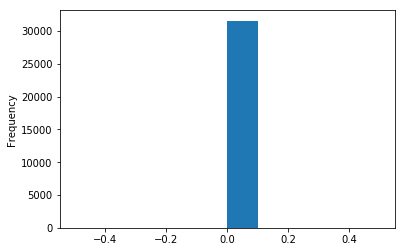

In [58]:
all_posts_df.num_downs.plot.hist(bins=10)

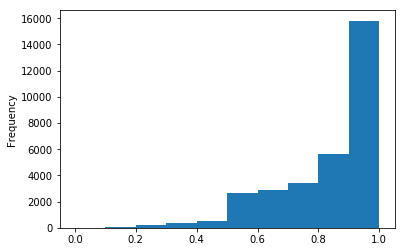

In [60]:
# Better signal that num_ups/num_downs--probably best available signal
all_posts_df.upvote_ratio.plot.hist(bins=10) 

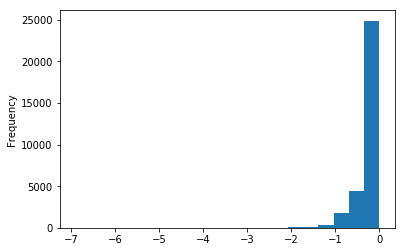

In [24]:
# Log upvote ratio:
all_posts_df.upvote_ratio.apply(lambda x: np.log(x+0.001)).plot.hist(bins=20) 

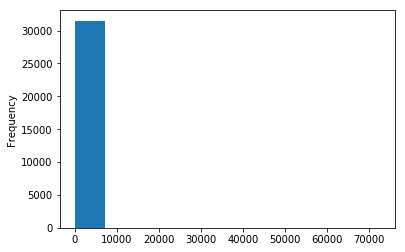

In [61]:
all_posts_df.score.plot.hist(bins=10)

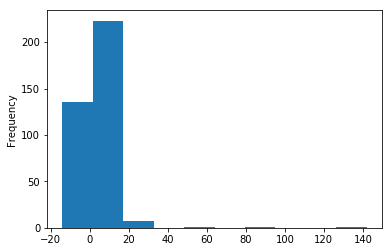

In [56]:
all_comments_df.num_ups.plot.hist(bins=10) # not a great signal

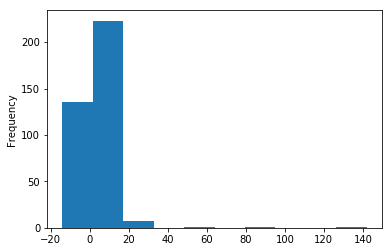

In [62]:
# Score is the same as num_ups
all_comments_df.score.plot.hist(bins=10)

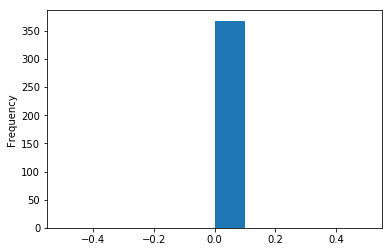

In [59]:
all_comments_df.num_downs.plot.hist(bins=10)

In [64]:
all_comments_df.num_likes#.plot.hist(bins=10)
# Comments don't have upvote ratio available as attribute

0    NaN
0    NaN
0    NaN
1    NaN
2    NaN
    ... 
0    NaN
1    NaN
2    NaN
0    NaN
1    NaN
Name: num_likes, Length: 371, dtype: object

In [82]:
# 63 posts are videos
all_posts_df.is_video.value_counts()

False    31505
True        63
Name: is_video, dtype: int64

## Explore general properties of text

In [67]:
all_comments_df.loc[all_comments_df.text.apply(lambda x: type(x) == float)]

,submission_id,author,text,date,id,controversiality,num_downs,num_ups,num_likes,score,subreddit,parsed_date,year,month
1,[And crock of the week too !](http://climatepr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


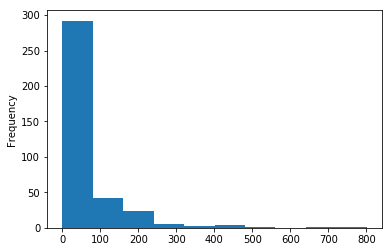

In [71]:
# Length of comments in "words" (split on whitespace)
all_comments_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0).plot.hist()

In [30]:
# Number of posts/comments with <=50 words, per Reid's threshold
all_comments_df['length'] = all_comments_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0)
all_posts_df['text_length'] = all_posts_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0)
all_posts_df['title_length'] = all_posts_df.title.apply(lambda x: len(x.split()) if type(x) != float else 0)
print(all_comments_df.loc[all_comments_df.length.apply(lambda x: x > 0 and x <= 50)].shape,
all_posts_df.loc[all_posts_df.text_length.apply(lambda x: x > 0 and x <= 50)].shape,
     all_posts_df.loc[all_posts_df.title_length.apply(lambda x: x > 0 and x <= 50)].shape)

(261, 15) (2460, 18) (32192, 18)


In [79]:
all_comments_df.text.apply(lambda x: len(x) if type(x) != float else 0).value_counts()

9      16
7       5
58      5
78      4
221     4
       ..
244     1
430     1
192     1
238     1
0       1
Name: text, Length: 263, dtype: int64

In [90]:
# Posts with title content: there are 32.2k (all have titles)
posts_with_titles = all_posts_df.loc[~pd.isnull(all_posts_df.title)]
posts_with_titles.shape

(32301, 15)

In [84]:
# Posts with text content: there are only 6.6k
posts_with_text = all_posts_df.loc[~pd.isnull(all_posts_df.text)]
posts_with_text.shape

(6620, 15)

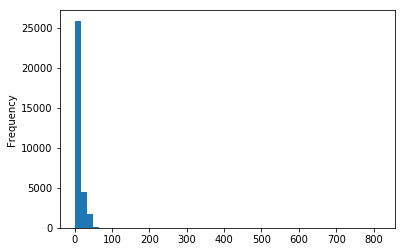

In [91]:
# Length of titles in whitespace-split "words"
posts_with_titles.title.apply(lambda x: len(x.split())).plot.hist(bins=50)

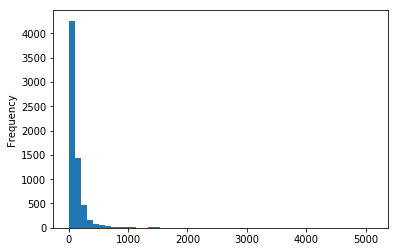

In [86]:
# Length of posts in whitespace-split "words"
posts_with_text.text.apply(lambda x: len(x.split())).plot.hist(bins=50)

In [92]:
# Titles
posts_with_titles.title.apply(lambda x: len(x.split())).value_counts()

9      2565
10     2499
8      2489
11     2386
7      2206
       ... 
73        1
58        1
156       1
61        1
815       1
Name: title, Length: 63, dtype: int64

In [88]:
# A lot of posts have 1 word?
posts_with_text.text.apply(lambda x: len(x.split())).value_counts()

1       144
32       67
38       65
22       63
34       62
       ... 
909       1
945       1
953       1
961       1
1843      1
Name: text, Length: 615, dtype: int64

In [89]:
posts_with_text.loc[posts_with_text.text.apply(lambda x: len(x.split()) == 1)]

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
26,Do you agree with -- and/or can you explain wh...,WentzToDJax,1.594729e+09,False,hqulpf,0.0,2.0,0.63,9.0,2.0,https://www.minnpost.com/eric-black-ink/2013/0...,askaconservative,2020-07-14 12:08:34,2020.0,7.0
161,What do you think about bayonets being issued ...,Lavaknight368,1.593848e+09,False,hktcbx,0.0,3.0,1.00,21.0,3.0,https://thehill.com/policy/defense/505717-mill...,askaconservative,2020-07-04 07:32:46,2020.0,7.0
311,How likely is Trump to win (%)?,renaissance_pancakes,1.592994e+09,False,hesd7h,0.0,5.0,0.70,23.0,5.0,Go.,askaconservative,2020-06-24 10:20:14,2020.0,6.0
507,Are there any good conservative historians who...,ActualStreet,1.592009e+09,False,h7o8lv,0.0,6.0,0.88,3.0,6.0,Thanks,askaconservative,2020-06-13 00:42:35,2020.0,6.0
627,What should happen to Kayleigh McEnany if she ...,fizzywater42,1.591473e+09,False,gxpnui,0.0,17.0,0.80,11.0,17.0,https://www.huffpost.com/entry/trump-maralago-...,askaconservative,2020-06-06 19:56:19,2020.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Alex O'Connor (A.K.A. Cosmic Skeptic) is curre...,Omnibeneviolent,1.594266e+09,False,hnntvy,0.0,10.0,0.72,0.0,10.0,https://www.reddit.com/r/vegan/comments/hnmyk0...,skeptic,2020-07-09 03:36:18,2020.0,7.0
167,I love science guys!,AmazingPineaple6,1.593731e+09,False,hjyncq,0.0,0.0,0.10,0.0,0.0,https://encrypted-tbn0.gstatic.com/images?q=tb...,skeptic,2020-07-02 23:04:38,2020.0,7.0
490,Virus man-made according to Norwegian researcher,oli_gendebien,1.591601e+09,False,gyn7bl,0.0,0.0,0.25,9.0,0.0,https://www.forbes.com/sites/davidnikel/2020/0...,skeptic,2020-06-08 07:23:49,2020.0,6.0
1,A new nature economy could generate up to $10....,clim8pablo,1.594849e+09,False,hrnlof,0.0,11.0,1.00,0.0,11.0,[https://www.weforum.org/reports/new-nature-ec...,sustainability,2020-07-15 21:31:58,2020.0,7.0
